![Screenshot 2025-09-04 044005.png](<attachment:Screenshot 2025-09-04 044005.png>)
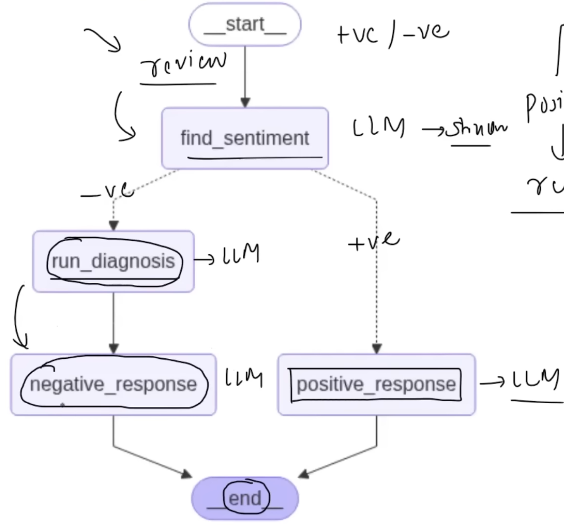

In [39]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [40]:
load_dotenv()

True

In [41]:
model = ChatOpenAI(model = 'gpt-4o-mini')

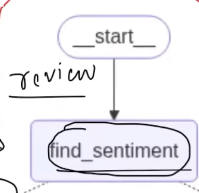

In [42]:
# schema for structured_output to get the sentiment:

class SentimentSchema(BaseModel):
    
    sentiment : Literal['positive','negative'] = Field(description="Sentiment of the review")
    

In [43]:
structured_model = model.with_structured_output(SentimentSchema)

In [44]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model.invoke(prompt).sentiment

'positive'

In [45]:
prompt = 'What is the sentiment of the following review - The software not good'
structured_model.invoke(prompt).sentiment

'negative'

In [46]:
# another structured output from run_diagnosis as there we want 3 variables as output

class DiagnosisSchema(BaseModel):
    
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [47]:
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [48]:
# creating the state

class ReviewState(TypedDict):
    
    review : str
    sentiment : Literal['positive','negative']
    diagnosis : dict
    response : str

In [49]:
def find_sentiment(state : ReviewState):
    
    prompt = f"For the following review, find out the sentiment \n {state['review']}"
    
    # we will get the sentiment
    sentiment = structured_model.invoke(prompt).sentiment
    
    return {'sentiment' : sentiment}

In [50]:
# function for condition

def check_sentiment(state : ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

In [51]:
def positive_response(state : ReviewState):
    
    prompt = f"""
    Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website.
    """
    
    response = model.invoke(prompt).content
    
    return {'response':response}

In [52]:
def run_diagnosis(state:ReviewState):
    
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
    """
    
    response = structured_model2.invoke(prompt) # this response will be a json type with 3 variables -> issue_type, tone, urgency
    
    return {'diagnosis' : response.model_dump()} # return all three variable as dictionary

In [53]:
def negative_response(state:ReviewState):
    
    diagnosis = state['diagnosis']
    
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message."""
    
    response = model.invoke(prompt).content
    
    return {'response': response}


In [54]:
graph = StateGraph(ReviewState)

# nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('negative_response', negative_response)


# edges
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response',END)

workflow = graph.compile()

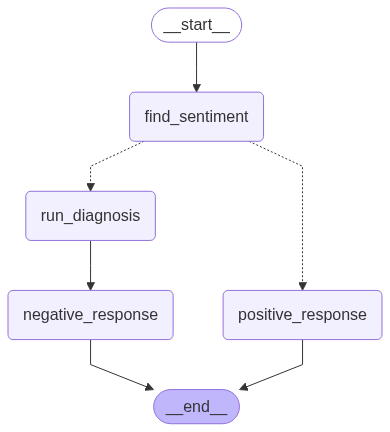

In [55]:
workflow

In [58]:
initial_state = {'review' : "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."}


result = workflow.invoke(initial_state)


In [62]:
result

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: We're Here to Help with Your Bug Issue\n\nHi [User's Name],\n\nI’m really sorry to hear you’re experiencing a bug, and I can understand how frustrating it must be. We truly appreciate your patience as we work to resolve this issue.\n\nTo help you effectively, could you please provide some additional details about the bug you’re facing? Specifically, if you could let me know what actions led up to the issue, any error messages you received, and the device or platform you’re using, that would be really helpful. \n\nOur team is committed to resolving this for you as quickly as possible, and your feedback will guide us in fi

In [60]:
result['review']

'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.'

In [61]:
result['sentiment']

'negative'

In [63]:
result['diagnosis']

{'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'}

In [64]:
result['response']

"Subject: We're Here to Help with Your Bug Issue\n\nHi [User's Name],\n\nI’m really sorry to hear you’re experiencing a bug, and I can understand how frustrating it must be. We truly appreciate your patience as we work to resolve this issue.\n\nTo help you effectively, could you please provide some additional details about the bug you’re facing? Specifically, if you could let me know what actions led up to the issue, any error messages you received, and the device or platform you’re using, that would be really helpful. \n\nOur team is committed to resolving this for you as quickly as possible, and your feedback will guide us in finding a solution. \n\nThank you for bringing this to our attention, and I look forward to assisting you further!\n\nBest regards,\n\n[Your Name]  \n[Your Position]  \n[Your Contact Information]  \n[Company Name]  \n"